In [2]:
import sys, os, imp
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.constants import c

C:\Users\alves\AppData\Local\Temp\ipykernel_22636\3705448658.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import sys, os, imp


In [3]:
lumapiFile = "/opt/lumerical/v221/api/python/lumapi.py"
lumapiFile = "C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py"
lumapi = imp.load_source("lumapi", lumapiFile)
interApi = lumapi.INTERCONNECT(hide = False)

In [4]:
interApi.expressioncheckoff()

In [5]:
# units
um = 1e-6
nm = 1e-9

Lc = 14*um
lr = np.array([552.82, 55.28, 27.64])*um

wavelength = 1550*nm

# index
neff = 2.3531702
ng = 4.3458796

wvlngth_start = 1.500 * um
wvlngth_stop = 1.600 * um

number_of_points = 50e3

# Simulation

## Add ONA

In [6]:
interApi.switchtolayout()
interApi.select('ONA')
interApi.delete()

# ONA

interApi.addelement('Optical Network Analyzer')
interApi.set('name', 'ONA')
interApi.set('number of input ports', 2)
interApi.set('input parameter', 2)
interApi.set('start frequency', c/wvlngth_start)
interApi.set('stop frequency', c/wvlngth_stop)
interApi.set('number of points', number_of_points)

## $FSR(\lambda)=1nn$

In [9]:
interApi.switchtolayout()
interApi.select('coupler_1')
interApi.delete()
interApi.select('coupler_2')
interApi.delete()
interApi.select('wg_1')
interApi.delete()
interApi.select('wg_2')
interApi.delete()

# Waveguide

interApi.addelement('ebeam_dc_te1550')
interApi.set('name', 'coupler_1')
interApi.set('coupling_length', Lc)

interApi.addelement('ebeam_dc_te1550')
interApi.set('name', 'coupler_2')
interApi.set('coupling_length', Lc)

radius = interApi.get('radius')

interApi.addelement('ebeam_wg_integral_1550')
interApi.set('name', 'wg_1')
interApi.set('wg_length', lr[0]/2 - (np.pi*radius + Lc))
interApi.set('Rotated', 45)
# interApi.set('wg_width', wvg_width)


interApi.addelement('ebeam_wg_integral_1550')
interApi.set('name', 'wg_2')
interApi.set('wg_length', lr[0]/2 - (np.pi*radius + Lc))
interApi.set('Rotated', 45)
# interApi.set('wg_width', wvg_width)

In [ ]:
#positions
interApi.setposition('ONA', -10, -600)
interApi.setposition('wg_1', 10,-100)
interApi.setposition('wg_2', 300, -100)
interApi.setposition('coupler_1', 200, 300)
interApi.setposition('coupler_2', 200, -300)

In [ ]:
# connection

interApi.connect("ONA", "output", "coupler_1", "opt_2")
interApi.connect("coupler_1", "opt_1", "wg_1", "port 2")
interApi.connect("coupler_1", "opt_3", "wg_2", "port 2")
interApi.connect("wg_1", "port 1", "coupler_2", "opt_2")
interApi.connect("wg_2", "port 1", "coupler_2", "opt_4")
interApi.connect("coupler_2", "opt_1", "ONA", "input 1")
interApi.connect("coupler_1", "opt_4", "ONA", "input 2")

1.0

In [ ]:
interApi.run()

### Transmission

In [ ]:
gain_1nm = interApi.getresult("ONA", "input 1/mode 1/gain")
wavelength_1 = gain_1nm['wavelength']
gain = gain_1nm["'TE' gain (dB)"]

gain_2_1nm = interApi.getresult("ONA", "input 2/mode 1/gain")
wavelength_2 = gain_2_1nm['wavelength']
gain_2 = gain_2_1nm["'TE' gain (dB)"]

C:\Users\alves\AppData\Local\Temp\ipykernel_24704\3256488238.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.text(1547, 0, f'{float(x_min_1 - x_min_2):.1f} nm', fontsize=12)


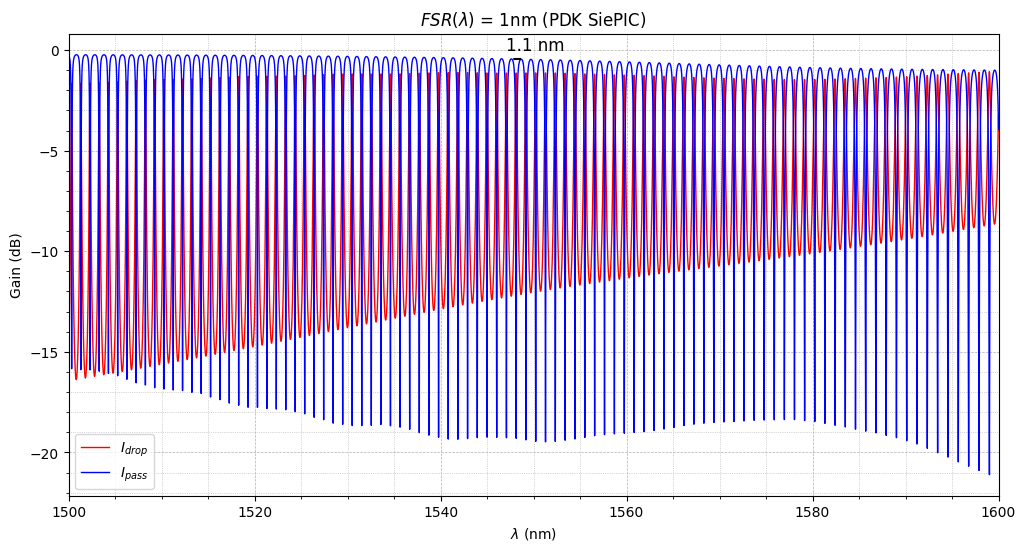

In [ ]:
min_indices, _ = find_peaks(np.array(gain_2))

if len(min_indices) >= 2:
    min_1, min_2 = min_indices[47:49]  
    x_min_1, x_min_2 = wavelength_2[min_1] / nm, wavelength_2[min_2] / nm
    y_min = gain_2[min_1]

    plt.figure(figsize=(12, 6))
    plt.plot(wavelength_1 / nm, gain, lw=1, label='$I_{drop}$', color='r')
    plt.plot(wavelength_2 / nm, gain_2, lw=1, label='$I_{pass}$', color='b')

    plt.hlines(y=y_min, xmin=x_min_1, xmax=x_min_2, color='black', linestyle='--')
    plt.text(1547, 0, f'{float(x_min_1 - x_min_2):.1f} nm', fontsize=12)

    plt.xlabel('$\lambda$ (nm)')
    plt.ylabel('Gain (dB)')
    plt.xlim([wvlngth_start/nm, wvlngth_stop/nm])
    
    plt.title('$FSR(\lambda)$ = 1nm (PDK SiePIC)')
    plt.minorticks_on()
    plt.grid(which='both', linestyle='--', linewidth=0.5)  
    plt.grid(which='minor', linestyle=':', linewidth=0.5) 

    plt.legend(loc='best')
    plt.savefig('FSR_1nm_PDK', bbox_inches='tight')
    plt.show()

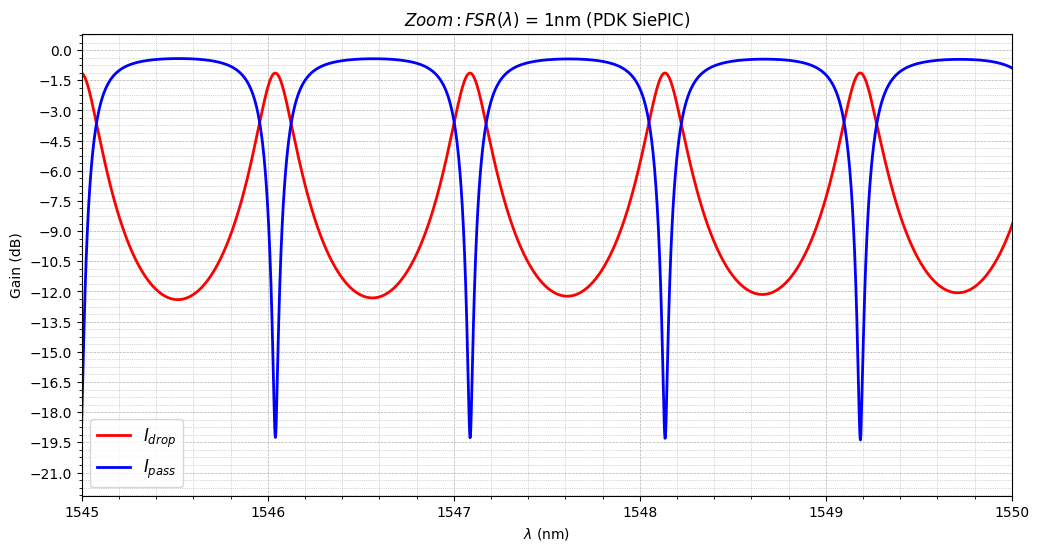

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(wavelength_1 / nm, gain, lw=2, label='$I_{drop}$', color='red')
plt.plot(wavelength_2 / nm, gain_2, lw=2, label='$I_{pass}$', color='blue')

plt.xlabel('$\lambda$ (nm)')
plt.ylabel('Gain (dB)')
plt.xlim([1545, 1550])

plt.gca().yaxis.set_major_locator(plt.MultipleLocator(1.5))
# plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(1)) 


plt.title('$Zoom: FSR(\lambda)$ = 1nm (PDK SiePIC)')
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)  
plt.grid(which='minor', linestyle=':', linewidth=0.5) 

plt.legend(loc='best', fontsize=12)
plt.savefig('FSR_1nm_PDK_zoom', bbox_inches='tight')
plt.show()

### FSR x wavelength

In [ ]:
FSR_1_1nm = interApi.getresult('ONA', 'input 1/mode 1/peak/free spectral range')
FSR_2_1nm = interApi.getresult('ONA', 'input 2/mode 1/peak/free spectral range')

wavelength_1 = np.array(FSR_1_1nm['wavelength']).flatten()
fsrplot_1 = np.array(FSR_1_1nm["'TE' free spectral range (m)"])

wavelength_2 = np.array(FSR_2_1nm['wavelength']).flatten()
fsrplot_2 = np.array(FSR_2_1nm["'TE' free spectral range (m)"])  

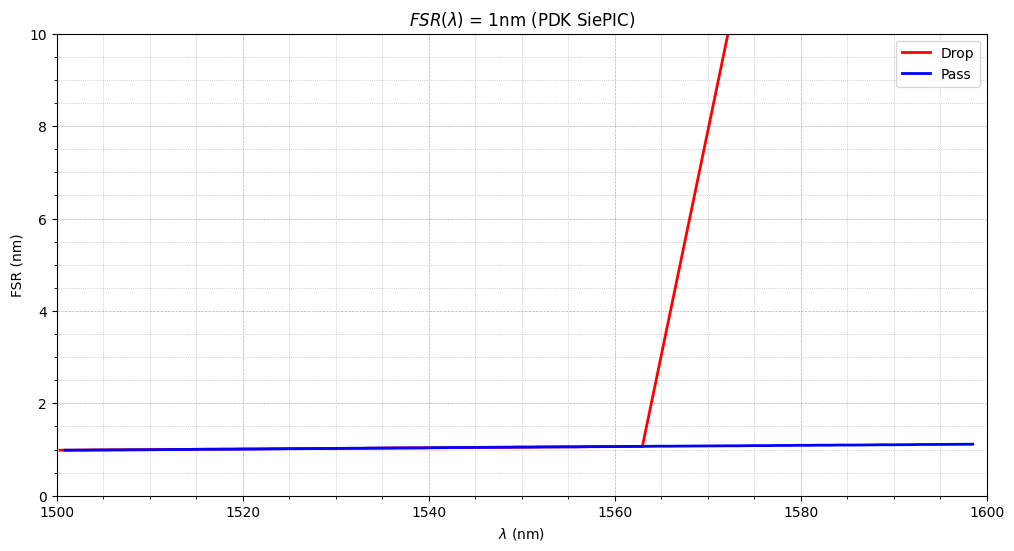

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(wavelength_1 / nm, fsrplot_1/nm, lw=2, label='Drop', color='r')
plt.plot(wavelength_2 / nm, fsrplot_2/nm, lw=2, label='Pass', color='b')

plt.xlabel('$\lambda$ (nm)')
plt.ylabel('FSR (nm)')
plt.xlim([wvlngth_start/nm, wvlngth_stop/nm])
plt.ylim([0, 10])
    
plt.title('$FSR(\lambda)$ = 1nm (PDK SiePIC)')
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)  
plt.grid(which='minor', linestyle=':', linewidth=0.5) 

plt.legend(loc='best')
plt.savefig('FSR_1nm_x_wvlength', bbox_inches='tight')
plt.show()

## $FSR(\lambda)=10nm$

In [10]:
interApi.switchtolayout()

interApi.select('wg_1')
interApi.delete()
interApi.select('wg_2')
interApi.delete()

Lc_10nm = 15*um

interApi.select('coupler_1')
interApi.set('coupling_length', Lc_10nm)

interApi.select('coupler_2')
interApi.set('coupling_length', Lc_10nm)

In [ ]:
# connection

# interApi.connect("ONA", "output", "coupler_1", "opt_2")
interApi.connect("coupler_1", "opt_1", "coupler_2", "opt_2")
interApi.connect("coupler_1", "opt_3", "coupler_2", "opt_4")
# interApi.connect("coupler_1", "opt_3", "wg_2", "port 2")
# interApi.connect("wg_1", "port 1", "coupler_2", "opt_2")
# interApi.connect("wg_2", "port 1", "coupler_2", "opt_4")
# interApi.connect("coupler_2", "opt_1", "ONA", "input 1")
# interApi.connect("coupler_1", "opt_4", "ONA", "input 2")

In [ ]:
interApi.run()

### Transmission

In [ ]:
gain_10nm = interApi.getresult("ONA", "input 1/mode 1/gain")
wavelength_1 = gain_10nm['wavelength']
gain = gain_10nm["'TE' gain (dB)"]

gain_2_10nm = interApi.getresult("ONA", "input 2/mode 1/gain")
wavelength_2 = gain_2_10nm['wavelength']
gain_2 = gain_2_10nm["'TE' gain (dB)"]

C:\Users\alves\AppData\Local\Temp\ipykernel_24704\1071398153.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.text(1538, -25, f'{float(x_min_1 - x_min_2):.1f} nm', fontsize=12)


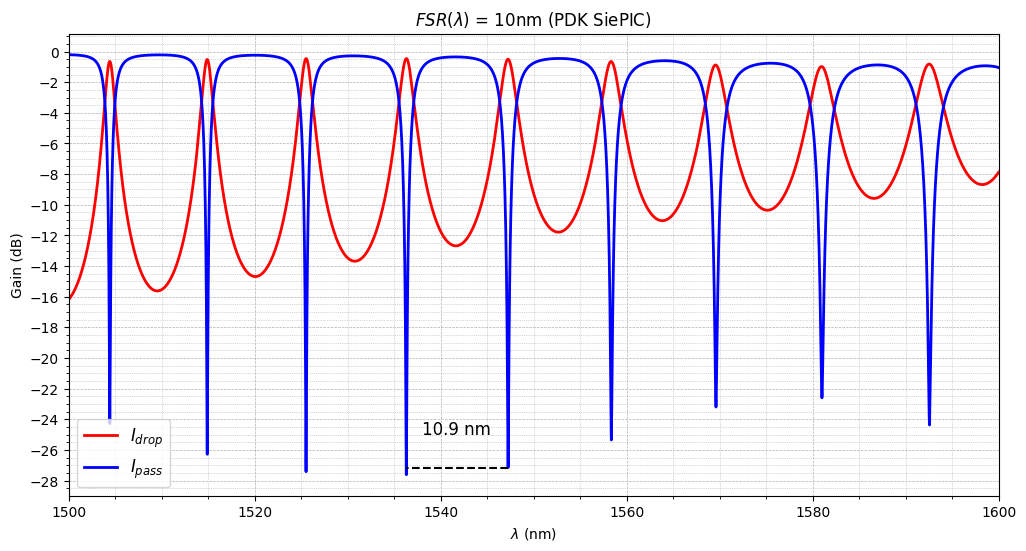

In [ ]:
min_indices, _ = find_peaks(np.array(-gain_2))

if len(min_indices) >= 2:
    min_1, min_2 = min_indices[4:6]  
    x_min_1, x_min_2 = wavelength_2[min_1] / nm, wavelength_2[min_2] / nm
    y_min = gain_2[min_1]

    plt.figure(figsize=(12, 6))
    plt.plot(wavelength_1 / nm, gain, lw=2, label='$I_{drop}$', color='r')
    plt.plot(wavelength_2 / nm, gain_2, lw=2, label='$I_{pass}$', color='b')

    plt.hlines(y=y_min, xmin=x_min_1, xmax=x_min_2, color='black', linestyle='--')
    plt.text(1538, -25, f'{float(x_min_1 - x_min_2):.1f} nm', fontsize=12)

    plt.xlabel('$\lambda$ (nm)')
    plt.ylabel('Gain (dB)')
    plt.xlim([wvlngth_start/nm, wvlngth_stop/nm])
    plt.gca().yaxis.set_major_locator(plt.MultipleLocator(2))
    
    plt.title('$FSR(\lambda)$ = 10nm (PDK SiePIC)')
    plt.minorticks_on()
    plt.grid(which='both', linestyle='--', linewidth=0.5)  
    plt.grid(which='minor', linestyle=':', linewidth=0.5) 

    plt.legend(loc='best', fontsize=12)
    plt.savefig('FSR_10nm_PDK', bbox_inches='tight')
    plt.show()

### FSR x wavelength

In [ ]:
FSR_1_10nm = interApi.getresult('ONA', 'input 1/mode 1/peak/free spectral range')
FSR_2_10nm = interApi.getresult('ONA', 'input 2/mode 1/peak/free spectral range')

wavelength_1 = np.array(FSR_1_10nm['wavelength']).flatten()
fsrplot_1 = np.array(FSR_1_10nm["'TE' free spectral range (m)"])

wavelength_2 = np.array(FSR_2_10nm['wavelength']).flatten()
fsrplot_2 = np.array(FSR_2_10nm["'TE' free spectral range (m)"])  

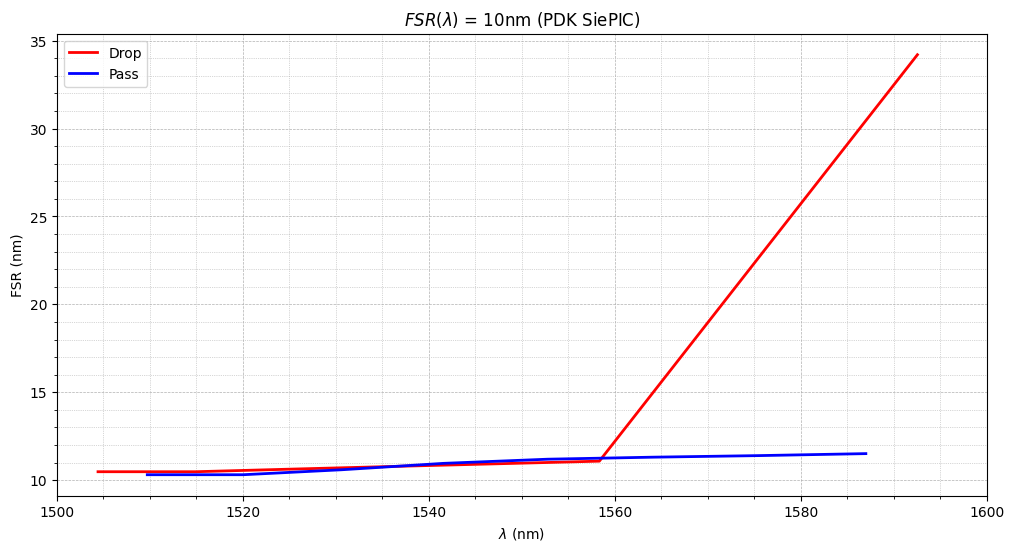

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(wavelength_1 / nm, fsrplot_1/nm, lw=2, label='Drop', color='r')
plt.plot(wavelength_2 / nm, fsrplot_2/nm, lw=2, label='Pass', color='b')

plt.xlabel('$\lambda$ (nm)')
plt.ylabel('FSR (nm)')
plt.xlim([wvlngth_start/nm, wvlngth_stop/nm])
    
plt.title('$FSR(\lambda)$ = 10nm (PDK SiePIC)')
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)  
plt.grid(which='minor', linestyle=':', linewidth=0.5) 

plt.legend(loc='best')
plt.savefig('FSR_10nm_x_wvlength', bbox_inches='tight')
plt.show()

## $FSR(\lambda)=20nm$

Double Ring Resonators
The FSR of the double ring resonator with two different radii is expressed by
$$FSR=M.FSR_1=N.FSR_2,$$
$$FSR=|M-N|\frac{FSR_1.FSR_2}{FSR_1-FSR_2}$$

In [7]:
fsr1 = 10*nm
fsr2 = 5*nm
fsr = 20*nm

m = fsr/fsr1
n = fsr/fsr2

Lr_5 = wavelength**2 / (ng*fsr2)
Lr_10 = wavelength**2 / (ng*fsr1)

print(f'{Lr_10:.2e}\n{Lr_5:.2e}')

5.53e-05
1.11e-04


In [27]:
interApi.switchtolayout()

interApi.select('coupler_1')
interApi.delete()
interApi.select('coupler_2')
interApi.delete()
interApi.select('coupler_3')
interApi.delete()
interApi.select('wg_1')
interApi.delete()
interApi.select('wg_2')
interApi.delete()

Lc_10nm = 15*um

interApi.addelement('ebeam_dc_te1550')
interApi.set('name', 'coupler_1')
interApi.set('coupling_length', Lc_10nm)

interApi.addelement('ebeam_dc_te1550')
interApi.set('name', 'coupler_2')
interApi.set('coupling_length', Lc_10nm)

interApi.addelement('ebeam_dc_te1550')
interApi.set('name', 'coupler_3')
interApi.set('coupling_length', Lc_10nm)

interApi.addelement('ebeam_wg_integral_1550')
interApi.set('name', 'wg_1')
interApi.set('wg_length', Lr_5/2 - (np.pi*radius + Lc_10nm))
interApi.set('Rotated', 45)
# interApi.set('wg_width', wvg_width)

interApi.addelement('ebeam_wg_integral_1550')
interApi.set('name', 'wg_2')
interApi.set('wg_length', Lr_5/2 - (np.pi*radius + Lc_10nm))
interApi.set('Rotated', 45)
# interApi.set('wg_width', wvg_width)

In [29]:
#positions
interApi.setposition('ONA', -300, -600)
interApi.setposition('wg_1', 0, -200)
interApi.setposition('wg_2', 400, -200)
interApi.setposition('coupler_1', 200, 300)
interApi.setposition('coupler_2', 200, 100)
interApi.setposition('coupler_3', 200, -400)

In [ ]:
# connection
interApi.connect("ONA", "output", "coupler_1", "opt_2")
interApi.connect("coupler_1", "opt_1", "coupler_2", "opt_2")
interApi.connect("coupler_1", "opt_3", "coupler_2", "opt_4")
interApi.connect("coupler_2", "opt_1", "wg_1", "port 2")
interApi.connect("coupler_2", "opt_3", "wg_2", "port 2")
interApi.connect("coupler_3", "opt_2", "wg_1", "port 1")
interApi.connect("coupler_3", "opt_4", "wg_2", "port 1")
interApi.connect("coupler_3", "opt_3", "ONA", "input 2")
interApi.connect("coupler_1", "opt_4", "ONA", "input 1")

1.0

In [32]:
interApi.run()

### Transmission

In [33]:
gain_20nm = interApi.getresult("ONA", "input 1/mode 1/gain")
wavelength_1 = gain_20nm['wavelength']
gain = gain_20nm["'TE' gain (dB)"]

gain_2_20nm = interApi.getresult("ONA", "input 2/mode 1/gain")
wavelength_2 = gain_2_20nm['wavelength']
gain_2 = gain_2_20nm["'TE' gain (dB)"]

C:\Users\alves\AppData\Local\Temp\ipykernel_22636\2511801940.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.text(1538, -25, f'{float(x_min_1 - x_min_2):.1f} nm', fontsize=12)


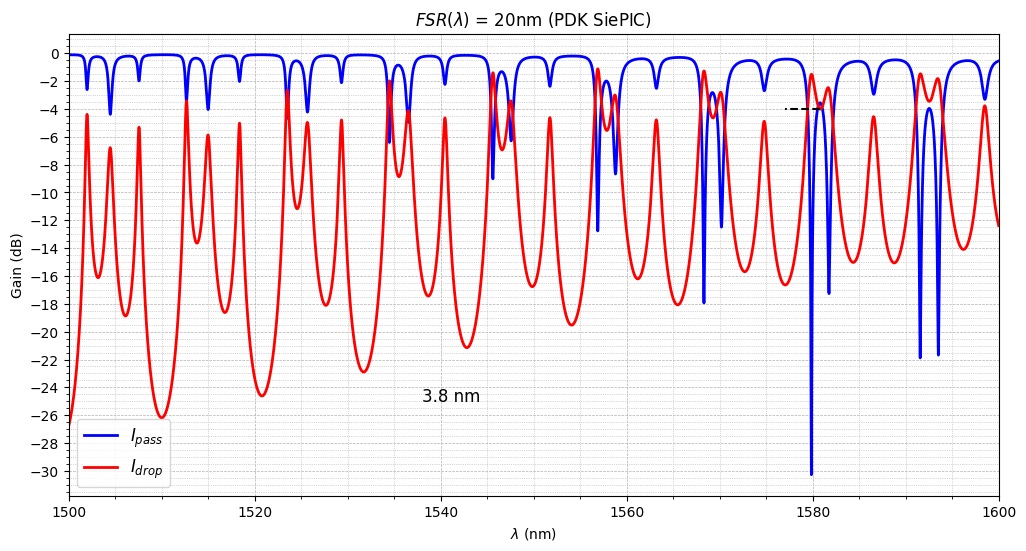

In [34]:
min_indices, _ = find_peaks(np.array(-gain_2))

if len(min_indices) >= 2:
    min_1, min_2 = min_indices[4:6]  
    x_min_1, x_min_2 = wavelength_2[min_1] / nm, wavelength_2[min_2] / nm
    y_min = gain_2[min_1]

    plt.figure(figsize=(12, 6))
    plt.plot(wavelength_1 / nm, gain, lw=2, label='$I_{pass}$', color='b')
    plt.plot(wavelength_2 / nm, gain_2, lw=2, label='$I_{drop}$', color='r')

    plt.hlines(y=y_min, xmin=x_min_1, xmax=x_min_2, color='black', linestyle='--')
    plt.text(1538, -25, f'{float(x_min_1 - x_min_2):.1f} nm', fontsize=12)

    plt.xlabel('$\lambda$ (nm)')
    plt.ylabel('Gain (dB)')
    plt.xlim([wvlngth_start/nm, wvlngth_stop/nm])
    plt.gca().yaxis.set_major_locator(plt.MultipleLocator(2))
    
    plt.title('$FSR(\lambda)$ = 20nm (PDK SiePIC)')
    plt.minorticks_on()
    plt.grid(which='both', linestyle='--', linewidth=0.5)  
    plt.grid(which='minor', linestyle=':', linewidth=0.5) 

    plt.legend(loc='best', fontsize=12)
    plt.savefig('FSR_20nm_PDK', bbox_inches='tight')
    plt.show()

### FSR x wavelength

In [35]:
FSR_1_20nm = interApi.getresult('ONA', 'input 1/mode 1/peak/free spectral range')
FSR_2_20nm = interApi.getresult('ONA', 'input 2/mode 1/peak/free spectral range')

wavelength_1 = np.array(FSR_1_20nm['wavelength']).flatten()
fsrplot_1 = np.array(FSR_1_20nm["'TE' free spectral range (m)"])

wavelength_2 = np.array(FSR_2_20nm['wavelength']).flatten()
fsrplot_2 = np.array(FSR_2_20nm["'TE' free spectral range (m)"])  

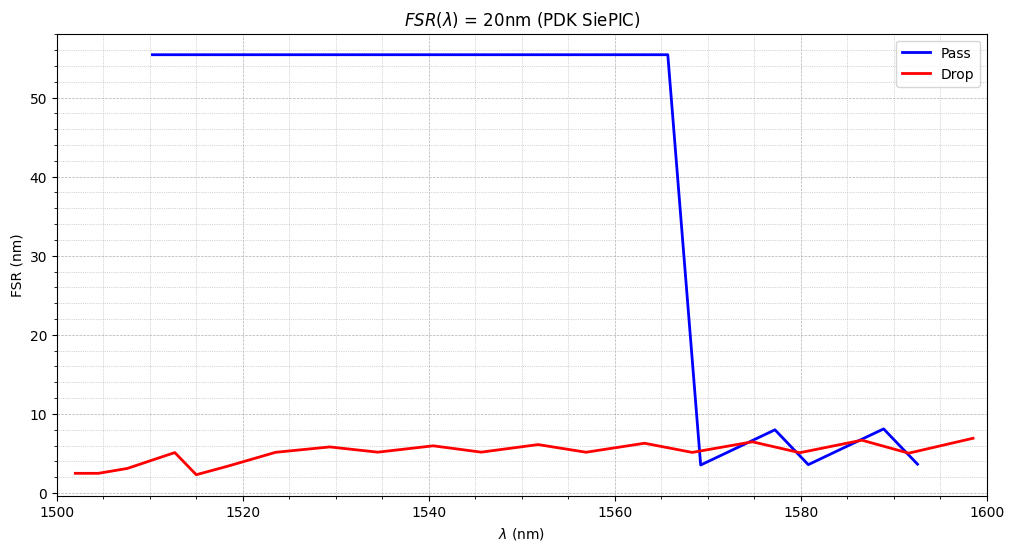

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(wavelength_1 / nm, fsrplot_1/nm, lw=2, label='Pass', color='blue')
plt.plot(wavelength_2 / nm, fsrplot_2/nm, lw=2, label='Drop', color='red')

plt.xlabel('$\lambda$ (nm)')
plt.ylabel('FSR (nm)')
plt.xlim([wvlngth_start/nm, wvlngth_stop/nm])
    
plt.title('$FSR(\lambda)$ = 20nm (PDK SiePIC)')
plt.minorticks_on()
plt.grid(which='both', linestyle='--', linewidth=0.5)  
plt.grid(which='minor', linestyle=':', linewidth=0.5) 

plt.legend(loc='best')
plt.savefig('FSR_20nm_x_wvlength', bbox_inches='tight')
plt.show()